# Data Treatment (Carcinos - Decaphoda Database)

In this notebook I'm doing all the data treatments and adjustments necessary to produce high quality visualizations. 

This notebook has an output <font color='blue'>treated_db.csv</font> with a subset of the original database properly treated.

-----

Specifically, for the `Decaphoda` database, the file we'll read is <font color='blue'>Planilha geral Atualizada FINAL 5_GERAL_sendo trabalhada no Google drive.xlsx</font>

## Imports

In [1]:
import datetime
import unidecode
import numpy as np
import pandas as pd

from collections import defaultdict

# quick visualizations for data analytics
import seaborn as sns
import matplotlib.pyplot as plt

# proprietary functions in ./src/MNViz.py
from src.MNViz import *

## Importing data

In [2]:
excel = pd.ExcelFile(
    './data/Planilha geral Atualizada FINAL 5_GERAL_sendo trabalhada no Google drive.xlsx')
sheet_name = excel.sheet_names

print('The excel file contains the following sheets:', sheet_name)
print('\nDatabase is in sheet:', sheet_name[0])

The excel file contains the following sheets: ['Banco de Dados Colecao Carcinol', 'Planilha1', 'Legenda cores']

Database is in sheet: Banco de Dados Colecao Carcinol


In [3]:
db = excel.parse(sheet_name[0], sep=';', encoding='utf-8-sig')
carcinos = db.copy()

print(f'The database has {db.shape[0]} rows and {db.shape[1]} columns.')

/home/franklin/anaconda3/envs/viz/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:300: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


The database has 31000 rows and 153 columns.


## Adjusting column names

### removing '\n', '\t', and other special characters

In [4]:
carcinos.columns = [str(col).replace(r'\n','') for col in carcinos.columns]

### There are a lot of `Unnamed` columns

Here we'll investigate to see if there's any data in these columns. If there is, there might be a reading problem.

In [5]:
# Unnamed columns
unnamed_cols = []
for col in carcinos.columns:
    if 'unnamed' in col.lower():
        unnamed_cols.append(col)
        
print(f'There is {len(unnamed_cols)} unnamed columns.')

There is 20 unnamed columns.


<AxesSubplot:>

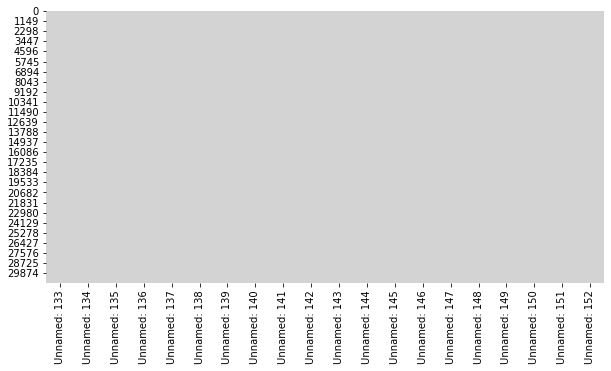

In [6]:
# If there's at least one red cell in the chart below, it's not safe to exclude the Unnamed columns from 
# the database. I recommend you take a further look into the database to check if there's some annotation 
# errors or, perhaps, you're using the special character ';' in some cells? 
subset = carcinos[unnamed_cols]

plt.figure(figsize=(10,5))
sns.heatmap(subset.isna(), vmin=0, vmax=1, cmap=['red', 'lightgray'], cbar=False)

#### short code to test if all unnamed columns are totally empty

In [7]:
empty_cols = []
for col in unnamed_cols:
    # if theres at least one non-empty cell, the sum of empty cells wont coincide with the number of lines
    if carcinos[col].isna().sum() != carcinos.shape[0]:
        print(f'p.s.: The column {col} is not fully empty! Please check that before moving on.')
    else:
        empty_cols.append(col)

#### If it's all good, we can remove those empty columns without any loss

In [8]:
carcinos.drop(empty_cols, axis=1, inplace=True)

## Adjusting Determiners and Collectors Names

In [9]:
# for col in carcinos.columns:
#     if 'collect' in col.lower():
#         print(col)

In [10]:
names_col = ['Determiner First Name1', 'Determiner Middle1', 'Determiner Last Name1',
             'Determiner First Name2', 'Determiner Middle2', 'Determiner Last Name2',
             'Collector First Name1', 'Collector Middle1', 'Collector Last Name1',
             'Collector First Name2', 'Collector Middle2', 'Collector Last Name2',
             'Collector First Name3', 'Collector Middle3', 'Collector Last Name3',
             'Collector First Name4', 'Collector Middle4', 'Collector Last Name4',
             'Collector First Name5', 'Collector Middle5', 'Collector Last Name5',
             'Collector First Name6', 'Collector Middle6', 'Collector Last Name6',
             'Collector First Name7', 'Collector Middle7', 'Collector Last Name7']

In [11]:
# skipping this for now. There are composite names that I can't just split

# for name_col in names_col:
#     if 'last' in name_col.lower():
#         carcinos[name_col] = carcinos[name_col].apply(lambda x: treat_names(x, pos='last'))
#     else:
#         carcinos[name_col] = carcinos[name_col].apply(treat_names)

In [12]:
# p.s.: Being careful to keep NaN
for name_col in names_col:
    if 'middle' not in name_col.lower():
        carcinos[name_col] = carcinos[name_col].apply(lambda x:str(x).strip().capitalize() if type(x) == str else str(x))
    else:
        carcinos[name_col] = carcinos[name_col].apply(lambda x:str(x).strip().lower().capitalize() if type(x) == str else str(x))

### creating column joining First and Last names

I'm doing this only for the first collectors and determiners

In [13]:
carcinos['DeterminerFirst_and_LastName1'] = carcinos['Determiner First Name1'] + ' ' + carcinos['Determiner Last Name1']

carcinos['CollectorFirst_and_LastName1'] = carcinos['Collector First Name1'] + ' ' + carcinos['Collector Last Name1']

Doing the same thing for the other columns (2,3,4,5 and 6)

In [14]:
for i in range(2, 8):    
    if i < 3:
        # determiner 
        carcinos[f'DeterminerFirst_and_LastName{i}'] = carcinos[f'Determiner First Name{i}'].astype(str).str.strip() + ' ' + carcinos[f'Determiner Last Name{i}'].astype(str).str.strip()
    
    # collector
    carcinos[f'CollectorFirst_and_LastName{i}'] = carcinos[f'Collector First Name{i}'].str.strip() + ' ' + carcinos[f'Collector Last Name{i}'].str.strip()

In [15]:
carcinos['DeterminerFirst_and_LastName2'].unique()

array(['nan nan', 'Priscila Nascimento', 'Walter Zwink',
       'Gustavo-augusto De melo', 'Paulo Young', 'Alexandre Leta',
       'H Pinto', '0 Thiery', 'A Mello', 'Cristiana Serejo', 'W Boeger',
       'J Luque', 'Maria-margarida Correa', 'Juliana Segadilha',
       'Fabio Mauro', 'None None'], dtype=object)

### Creating column with FULL name (first + middle + last names)

In [16]:
carcinos['DeterminerFullName1'] = carcinos['Determiner First Name1'] + ' ' + carcinos['Determiner Middle1'] + ' ' + carcinos['Determiner Last Name1']

carcinos['CollectorFullName1'] = carcinos['Collector First Name1'] + ' ' + carcinos['Collector Middle1'] + ' ' + carcinos['Collector Last Name1']

In [17]:
for i in range(2, 8):    
    if i < 3:
        # determiner 
        carcinos[f'DeterminerFullName{i}'] = carcinos[f'Determiner First Name{i}'].astype(str).str.strip() + ' ' + carcinos[f'Determiner Middle{i}'].astype(str).str.strip() + ' ' + carcinos[f'Determiner Last Name{i}'].astype(str).str.strip()
    
    # collector
    carcinos[f'CollectorFullName{i}'] = carcinos[f'Collector First Name{i}'].str.strip() + ' ' + carcinos[f'Collector Middle{i}'].str.strip() + ' ' + carcinos[f'Collector Last Name{i}'].str.strip()

## Author names...

In [18]:
author_cols = []
for col in carcinos.columns:
    if 'author' in col.lower():
        author_cols.append(col)

In [19]:
carcinos[author_cols]

,Species Author Name 1,Species Author Year 1,SpeciesAuthorInfo1,Species Author Parentheses 1,Species Author Name 2,Species Author Year 2,SpeciesAuthorInfo2,Species Author Parentheses 2
0,Burkenroad,1936.0,NaN,NO,NaN,NaN,NaN,NaN
1,Burkenroad,1936.0,NaN,NO,NaN,NaN,NaN,NaN
2,Burkenroad,1936.0,NaN,NO,NaN,NaN,NaN,NaN
3,Hobbs III,1979.0,NaN,NO,NaN,NaN,NaN,NaN
4,Burkenroad,1936.0,NaN,NO,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
30995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
author_cols = ['Species Author Name 1', 'Species Author Name 2']

In [21]:
carcinos['Author1'] = carcinos['Species Author Name 1'].apply(lambda x:str(x).strip().lower().capitalize())
carcinos['Author2'] = carcinos['Species Author Name 2'].apply(lambda x:str(x).strip().lower().capitalize())

<br>

## Treating taxon columns

In [22]:
# OBS: continuar a partir daqui!!!
taxon_columns = ['Kingdom', 'Phylum1', 'Subphylum1', 'Class1', 'Subclass1', 'Infraclass1',  
                 'Superorder1', 'Order1', 'Suborder1', 'Infraorder1',  'Superfamily1', 'Family1',
                 'Subfamily1', 'Tribe1', 'Genus1', 'Species1',
                 'Type Status1']  # selecting taxonomy columns

treat_taxon_columns(carcinos, taxon_columns)

Adjusting column Kingdom
Adjusting column Phylum1
Adjusting column Subphylum1
Adjusting column Class1
Adjusting column Subclass1
Adjusting column Infraclass1
Adjusting column Superorder1
Adjusting column Order1
Adjusting column Suborder1
Adjusting column Infraorder1
Adjusting column Superfamily1
Adjusting column Family1
Adjusting column Subfamily1
Adjusting column Tribe1
Adjusting column Genus1
Adjusting column Species1
Adjusting column Type Status1


## Adjusting Gender and Species

In [23]:
# dica do especialista: epiteto especifico deve ser todo minusculo (especie e subespecie, nesse caso)
carcinos['Species1'] = carcinos['Species1'].str.lower()

<br>

### Treating Type column

In [24]:
def correct_type(t):
    '''
    Given a type input, it correctly returns the name of the type (Corrects for spelling mistakes 
    and some known errors)
    '''
    # list of known types
    types = ['Parátipo', 'Holótipo', 'Alótipo', 'Neótipo', 'Paralectótipo', 'Topótipo', 'Síntipo', 'Lectótipo']
    normalized_types = {unidecode.unidecode(j):j for j in types}  # corrects for accents errors
    
    t = str(t).strip().capitalize()
    if t in types:
        return t
    elif t in normalized_types.keys():
        return normalized_types[t]
    elif t == 'None' or t == 'Nan':
        return np.NAN
    else:  # still don't know what to do with 'Tipo, Co-tipo and Material tipo'.
        return t

In [25]:
carcinos['Type Status1'] = carcinos['Type Status1'].apply(correct_type)
carcinos['Type Status1'].value_counts()

Parátipo         929
Holótipo         303
Alótipo           86
Neótipo            7
Paralectótipo      6
Topótipo           6
Síntipo            5
Lectótipo          4
Material tipo      4
Tipo               2
Co-tipo            1
Neotype            1
Name: Type Status1, dtype: int64

## Catching Month and Year

date_columns= ['Cataloged Date','Determined Date1','Determined Date2', 'Start Date'] 

In [26]:
# carcinos['Determined Date1'].unique()

In [27]:
def get_year(date):
    '''
    Expected format: YYYY/mm/dd
    '''
    date = str(date).replace('-','/')
    if date.lower() == 'nan':
        return np.NAN
    else:
        return date.split('/')[0]
    
def get_month(date):
    '''
    Expected format: YYYY/mm/dd
    '''
    date = str(date).replace('-','/')
    if date.lower() == 'nan':
        return np.NAN
    elif len(date.split('/')) >= 2:
        return date.split('/')[1]
    else:
        return date

In [28]:
# carcinos['Determined Date1'].apply(get_month).value_counts(dropna=False)

In [70]:
carcinos['det_year'] = carcinos['Determined Date1'].apply(get_year)
carcinos['det_year2'] = carcinos['Determined Date2'].apply(get_year)
carcinos['start_year'] = carcinos['Start Date'].apply(get_year)
carcinos['catalog_year'] = carcinos['Cataloged Date'].apply(get_year)

carcinos['det_month'] = carcinos['Determined Date1'].apply(get_month)
carcinos['det_month2'] = carcinos['Determined Date2'].apply(get_month)
carcinos['start_month'] = carcinos['Start Date'].apply(get_month)
carcinos['catalog_month'] = carcinos['Cataloged Date'].apply(get_month)

converting to int

In [30]:
# skipping this for now as there are still many non-integers in these columns (probably errors)

# repteis['ano_determinacao'] = repteis['ano_determinacao'].apply(str_with_nan2int) #has NaN
# repteis['ano_coleta'] = repteis['ano_coleta'].apply(str_with_nan2int) #has NaN
# repteis['ano_entrada'] = repteis['ano_entrada'].apply(str_with_nan2int) #has NaN

# repteis['mes_determinacao'] = repteis['mes_determinacao'].apply(str_with_nan2int) #has NaN
# repteis['mes_coleta'] = repteis['mes_coleta'].apply(str_with_nan2int) #has NaN
# repteis['mes_entrada'] = repteis['mes_entrada'].apply(str_with_nan2int) #has NaN

<br>

## Adjusting `Depth` columns

<font color='red'>**p.s.:** I'm assuming it's all on the same unit measure (in meters) </font>

In [31]:
def get_depth(d):
    '''
    Treats known errors in Depth columns
    '''
    
    d = str(d)
    
    if d.lower() == 'nan' or d.lower() == 'none':
        return np.NAN
    else:
        return d.replace(',','.').replace('m','').strip()

In [145]:
carcinos['min_depth'] = carcinos['StartDepth'].apply(get_depth)
carcinos['max_depth'] = carcinos['EndDepth'].apply(get_depth)

# converting to float (keeping NaN)
carcinos['min_depth'] = carcinos['min_depth'].apply(convert2float)
carcinos['max_depth'] = carcinos['max_depth'].apply(convert2float)

In [ ]:
# (sanity check) startdepth cells in which StartDepth is nonempty and min_depth is
# carcinos[(~carcinos['StartDepth'].isna()) & (carcinos['min_depth'].isna())][['StartDepth', 'min_depth']]

In [146]:
# p.s.: some specimens were found above sea level!!!
carcinos[~carcinos['MinElevation'].isna()][['StartDepth', 'min_depth', 'MinElevation']]

,StartDepth,min_depth,MinElevation
11329,NaN,NaN,1400.0
12256,NaN,NaN,1500.0
18181,NaN,NaN,1500.0
23051,NaN,NaN,740.0
23052,NaN,NaN,740.0
23053,NaN,NaN,740.0
23310,NaN,NaN,340.0
23404,NaN,NaN,350.0
24806,NaN,NaN,855.0
24810,NaN,NaN,1761.0


In [147]:
# test code to see if some depth values will be thrown away when incorporating elevation measures
temp = carcinos[~carcinos['MinElevation'].isna()] 

if temp['StartDepth'].isna().sum() != temp.shape[0]:
    # if the total empty cells in Start Depth != total non-empty cells MinElevation
    print('Some DEPTH values may be overlaid when adding ELEVATION measures.')
    print('Please check that before moving on...')

In [148]:
values = []
for depth, elev in zip(carcinos['min_depth'], carcinos['MinElevation']):
    if np.isnan(depth) and ~np.isnan(elev):
        values.append(-elev)  # negative depth means measures above sea level (convention)
    else:
        values.append(depth)

<br>

## Adjusting Latitude and Longitude

columns: ['Longitude1', 'Latitude1']

In [33]:
for col in carcinos.columns:
    if 'lat' in col.lower():
        print(col)

Latitude1
Latitude/Longitude Type
Lat/Long Method


In [34]:
carcinos['Longitude1'].unique()

array(['48.528374 W', nan, '43.640745 W', ..., -34550000, -38100000,
       -36383333], dtype=object)

In [35]:
def correct_coord(x):
    x = str(x).lower()
    
    if x == 'nan':
        return np.NAN
    elif '-' in x and '.' not in x:
        return x[:2] + '.' + x[2:].split(' ')[0]
    elif '.' not in x:
        return x[:2] + '.' + x[2:].split(' ')[0]
    else:
        return x.split(' ')[0]

In [36]:
carcinos['lat'] = carcinos['Latitude1'].apply(correct_coord)
carcinos['long'] = carcinos['Longitude1'].apply(correct_coord)

# converting to float
carcinos['lat'] = carcinos['lat'].apply(convert2float)
carcinos['long'] = carcinos['long'].apply(convert2float)

<br>

## Locality columns and creating column with brazilian regions

columns: ['Environment Type','Locality Name','waterBody','Continent', 'Country', 'State', 'County']

<font color='red' size='5'><b>Continuar a partir daqui!!!</b></font>

In [37]:
# p.s.: there are still some errors to treat here (only removing accents)
carcinos['Environment Type'] = carcinos['Environment Type'].apply(lambda x:unidecode.unidecode(str(x)))
carcinos['waterBody'] = carcinos['waterBody'].apply(lambda x:unidecode.unidecode(str(x)))
carcinos['Continent'] = carcinos['Continent'].apply(lambda x:unidecode.unidecode(str(x)))

In [38]:
correct_states = {
    # Norte
    'acre':'Acre',
    'amazonas':'Amazonas',
    'amapa':'Amapá',
    'para':'Pará',
    'rondonia':'Rondônia',
    'roraima':'Roraima',
    'tocantins':'Tocantins',
    # Nordeste
    'ceara':'Ceará',
    'maranhao':'Maranhão',
    'piaui':'Piauí',
    'rio grande do norte':'Rio Grande do Norte',
    'paraiba':'Paraíba',
    'pernambuco':'Pernambuco',
    'alagoas':'Alagoas',
    'sergipe':'Sergipe',
    'bahia':'Bahia',
    # Sudeste
    'rio de janeiro':'Rio de Janeiro',
    'espirito santo':'Espírito Santo',
    'sao paulo':'São Paulo',
    # Centro-oeste
    'mato grosso':'Mato Grosso',
    'mato grosso do sul':'Mato Grosso do Sul',
    'goias':'Goiás',
    'minas gerais':'Minas Gerais',
    # Sul
    'parana':'Paraná',
    'santa catarina':'Santa Catarina',
    'rio grande do sul':'Rio Grande do Sul'
}

def correct_state(state, correct_states):
    '''
    Corrects the writing of states' names.
    '''
    temp = str(state).lower()
    temp = unidecode.unidecode(temp)
    
    try:
        return correct_states[temp]
    except:
        return state  # remains unchanged in case it's a non-brazilian state

In [45]:
carcinos['State'] = carcinos['State'].apply(lambda x: correct_state(x, correct_states))

In [46]:
# brazilian region
carcinos['braz_region'] = carcinos['State'].apply(brazilian_region)

<br>

## Selecting Subset of Main DB

In [68]:
# for col in carcinos.columns:
#     if 'date' in col.lower():
#         print(col)

In [151]:
selected_columns = ['Acronimo+CatalogNumber','CatalogNumber', 'DeterminerFirst_and_LastName1',
                    'DeterminerFirst_and_LastName2', 'CollectorFirst_and_LastName1', 
                    'CollectorFirst_and_LastName2', 'CollectorFirst_and_LastName3',
                    'CollectorFirst_and_LastName4', 'CollectorFirst_and_LastName5',
                    'CollectorFirst_and_LastName6', 'CollectorFirst_and_LastName7',
                    'DeterminerFullName1', 'DeterminerFullName2', 'CollectorFullName1',
                    'CollectorFullName2', 'CollectorFullName3', 'CollectorFullName4',
                    'CollectorFullName5', 'CollectorFullName6', 'CollectorFullName7',
                    'Author1', 'Author2', 'Kingdom', 'Phylum1', 'Subphylum1', 'Class1', 'Subclass1', 
                    'Infraclass1', 'Superorder1', 'Order1', 'Suborder1', 'Infraorder1',  'Superfamily1', 
                    'Family1', 'Subfamily1', 'Tribe1', 'Genus1', 'Species1', 'Type Status1', 'Qualifier1',
                    'det_year', 'det_year2', 'start_year', 'catalog_year',
                    'det_month', 'det_month2', 'start_month', 'catalog_month',
                    'Determined Date1', 'Determined Date2', 'Start Date', 'Cataloged Date',
                    'min_depth', 'max_depth', 'depth', 'lat', 'long',
                    'Environment Type','Locality Name','waterBody','Continent', 'Country', 'State', 'County',
                    'braz_region']

In [152]:
NewTable = carcinos[selected_columns].copy()

## Renaming columns

Setting new standardized column names to facilitate future steps.

In [153]:
renames = {
    'DeterminerFirst_and_LastName1':'determiner_first_and_last_name',
    'DeterminerFirst_and_LastName2':'determiner_first_and_last_name2',
    'CollectorFirst_and_LastName1':'collector_first_and_last_name',
    'CollectorFirst_and_LastName2':'collector_first_and_last_name2',
    'CollectorFirst_and_LastName3':'collector_first_and_last_name3',
    'CollectorFirst_and_LastName4':'collector_first_and_last_name4',
    'CollectorFirst_and_LastName5':'collector_first_and_last_name5',
    'CollectorFirst_and_LastName6':'collector_first_and_last_name6',
    'CollectorFirst_and_LastName7':'collector_first_and_last_name7',
    'DeterminerFullName1':'determiner_full_name',
    'DeterminerFullName2':'determiner_full_name2',
    'CollectorFullName1':'collector_full_name',
    'CollectorFullName2':'collector_full_name2',
    'CollectorFullName3':'collector_full_name3',
    'CollectorFullName4':'collector_full_name4',
    'CollectorFullName5':'collector_full_name5',
    'CollectorFullName6':'collector_full_name6',
    'CollectorFullName7':'collector_full_name7',
    'Author1':'author',
    'Author2':'author2',
    'Determined Date1':'det_date', 
    'Determined Date2':'det_date2', 
    'Start Date':'start_date', 
    'Cataloged Date':'catalog_date',
    'Kingdom':'kingdom', 
    'Phylum1':'phylum', 
    'Subphylum1':'subphylum', 
    'Class1':'class', 
    'Subclass1':'subclass',
    'Infraclass1':'infraclass',
    'Superorder1':'superorder',
    'Order1':'order',
    'Suborder1':'suborder',
    'Infraorder1':'infraorder',
    'Superfamily1':'superfamily',
    'Family1':'family',
    'Subfamily1':'subfamily',
    'Tribe1':'tribe',
    'Genus1':'genus',
    'Species1':'species',
    'Type Status1':'type_status',
    'Qualifier1':'qualifier',
    'Environment Type':'environment',
    'Locality Name':'locality',
    'waterBody':'water_body',
    'Continent':'continent', 
    'Country':'country', 
    'State':'state', 
    'County':'county',
}

In [154]:
NewTable = NewTable.rename(columns=renames)

<br>

## Exporting to `CSV`

name: <font color='blue'>./src/treated_db.csv</font>
sep: ';'
encoding: 'utf-8-sig'

In [155]:
NewTable.to_csv('./data/treated_db.csv', sep=';', encoding='utf-8-sig')